In [1]:
##IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
###MAKE FIGURE FOR ONE DATASET

def make_figure(df):
    # ──────────────────────────────────────────────────────────────
    # 0.  Data   (df must have columns:  'label'  and  'score')
    #     label 0 = inlier (negative), 1 & 2 = different outlier classes
    # ──────────────────────────────────────────────────────────────
    labels  = df['label'].to_numpy()
    scores  = df['copod_scores'].to_numpy()

    # ──────────────────────────────────────────────────────────────
    # 1.  Determine the global FPR corresponding to the top-10 000
    #     most-anomalous objects
    # ──────────────────────────────────────────────────────────────
    N_TOP             = 2500
    sorted_idx        = np.argsort(scores)[::-1]          # descending
    top_idx           = sorted_idx[:N_TOP]
    n_inliers_topN    = np.sum(labels[top_idx] == 0)      # false positives
    total_inliers     = np.sum(labels == 0)

    fpr_10k           = n_inliers_topN / total_inliers    # may be 0 … 1
    fpr_10k           = min(max(fpr_10k, 1e-12), 1.0)     # keep inside (0,1]

    print(f"Top {N_TOP:,} anomalies ⇒ FPR = {fpr_10k:.4g}")

    # ──────────────────────────────────────────────────────────────
    # 2.  Side-by-side ROC curves truncated at fpr_10k
    # ──────────────────────────────────────────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300, sharey=True)

    for ax, cls in zip(axes, (1, 2)):
        mask        = (labels == 0) | (labels == cls)         # inliers + this class
        y_true      = (labels[mask] == cls).astype(int)       # 1 = cls, 0 = inlier
        y_score     = scores[mask]

        # Full ROC
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1, drop_intermediate=False)  # :contentReference[oaicite:0]{index=0}

        # Truncate at fpr_10k
        keep              = fpr <= fpr_10k
        fpr_trunc, tpr_trunc = fpr[keep], tpr[keep]

        # Pad a final point exactly at fpr_10k if needed
        if fpr_trunc[-1] < fpr_10k:
            fpr_trunc = np.append(fpr_trunc, fpr_10k)
            tpr_trunc = np.append(tpr_trunc, tpr_trunc[-1])

        # Partial AUC, normalised to [0,1] over [0, fpr_10k]
        p_auc = roc_auc_score(y_true, y_score, max_fpr=fpr_10k)   # :contentReference[oaicite:1]{index=1}

        # Plot
        ax.plot(fpr_trunc, tpr_trunc, lw=1.5,
                label=fr"AUC = {p_auc:.3f}")
        ax.set_xlim(0, fpr_10k)
        ax.set_ylim(0, 1)
        ax.set_xlabel("False-positive rate")
        ax.set_title(f"Class {cls} vs. inliers")
        ax.legend(frameon=False)

    axes[0].set_ylabel("True-positive rate")
    plt.tight_layout()
    plt.show()


In [4]:
# ─── PROCESSING ────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

data_path    = '/mnt/deepstore/Final_DeepPhenotyping/pipeline/output/spike_0428/'
slides       = [s for s in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, s))]
FPR_MAX      = 0.001243
GRID_POINTS  = 200
CLASSES      = (1, 2)

# your three detectors
detectors = {
    'COPOD':    'copod_scores',
    'ECOD':     'ecod_scores',
    'iForest':  'iforest_scores'
}

# two pipelines: CL vs Engineered
pipelines = {
    'CL':         lambda slide: os.path.join(data_path, slide, f'{slide}_OD.parquet.gz'),
    'Engineered': lambda slide: os.path.join(data_path, slide, f'{slide}_trad_OD.parquet.gz'),
    'Eng PCA': lambda slide: os.path.join(data_path, slide, f'{slide}_trad_PCA_OD.parquet.gz')
}

# common FPR grid
fpr_grid = np.linspace(0, FPR_MAX, GRID_POINTS)

# nested dict: detector → class → pipeline → list of interp’d TPR arrays
tpr_curves = {
    det: { cls: {pipe: [] for pipe in pipelines} for cls in CLASSES }
    for det in detectors
}

for slide in slides:
    print(f'Processing {slide}')
    #skip slides 0B60114, 0B68520, 0B8B306
    if slide in ['0B60114', '0B68520', '0B8B306']:
        print(f"  skip {slide}")
        continue
    for pipe_name, path_fn in pipelines.items():
        fn = path_fn(slide)
        if not os.path.exists(fn):
            print(f"  skip {pipe_name}: file not found")
            continue

        df = pd.read_parquet(fn)
        y  = df['label'].to_numpy()

        for det_name, score_col in detectors.items():
            s = df[score_col].to_numpy()

            for cls in CLASSES:
                if np.sum(y == cls) == 0:
                    continue

                mask    = (y == 0) | (y == cls)
                y_true  = (y[mask] == cls).astype(int)
                y_score = s[mask]

                fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=False)
                keep        = fpr <= FPR_MAX
                fpr, tpr    = fpr[keep], tpr[keep]

                # pad horizontal to FPR_MAX
                if fpr[-1] < FPR_MAX:
                    fpr = np.append(fpr, FPR_MAX)
                    tpr = np.append(tpr, tpr[-1])

                # interpolate onto common grid
                tpr_interp = np.interp(fpr_grid, fpr, tpr,
                                       left=0, right=tpr[-1])
                tpr_curves[det_name][cls][pipe_name].append(tpr_interp)


Processing 0B68620
Processing 0B60414
Processing 0B87816
Processing 0B87911
Processing 0B68720
Processing 0B8B306
  skip 0B8B306
Processing 0B68520
  skip 0B68520
Processing 0B60214
Processing 0B60314
Processing 0B87711
Processing 0B60114
  skip 0B60114
Processing 0B68820


In [5]:
# === Scientific Reports figure style ===
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams.update({
    "font.family":     "Helvetica",   # Sci Rep: single sans-serif family
    "font.size":        8,            # 8 pt everywhere after reduction
    "axes.labelsize":   8,
    "axes.titlesize":   8,
    "xtick.labelsize":  8,
    "ytick.labelsize":  8,
    "legend.fontsize":  8,
    "lines.linewidth":  0.6,          # ≥0.5 pt after final sizing
    "figure.dpi":       300,
})
sns.set_theme(context="paper", style="ticks", rc=mpl.rcParams)


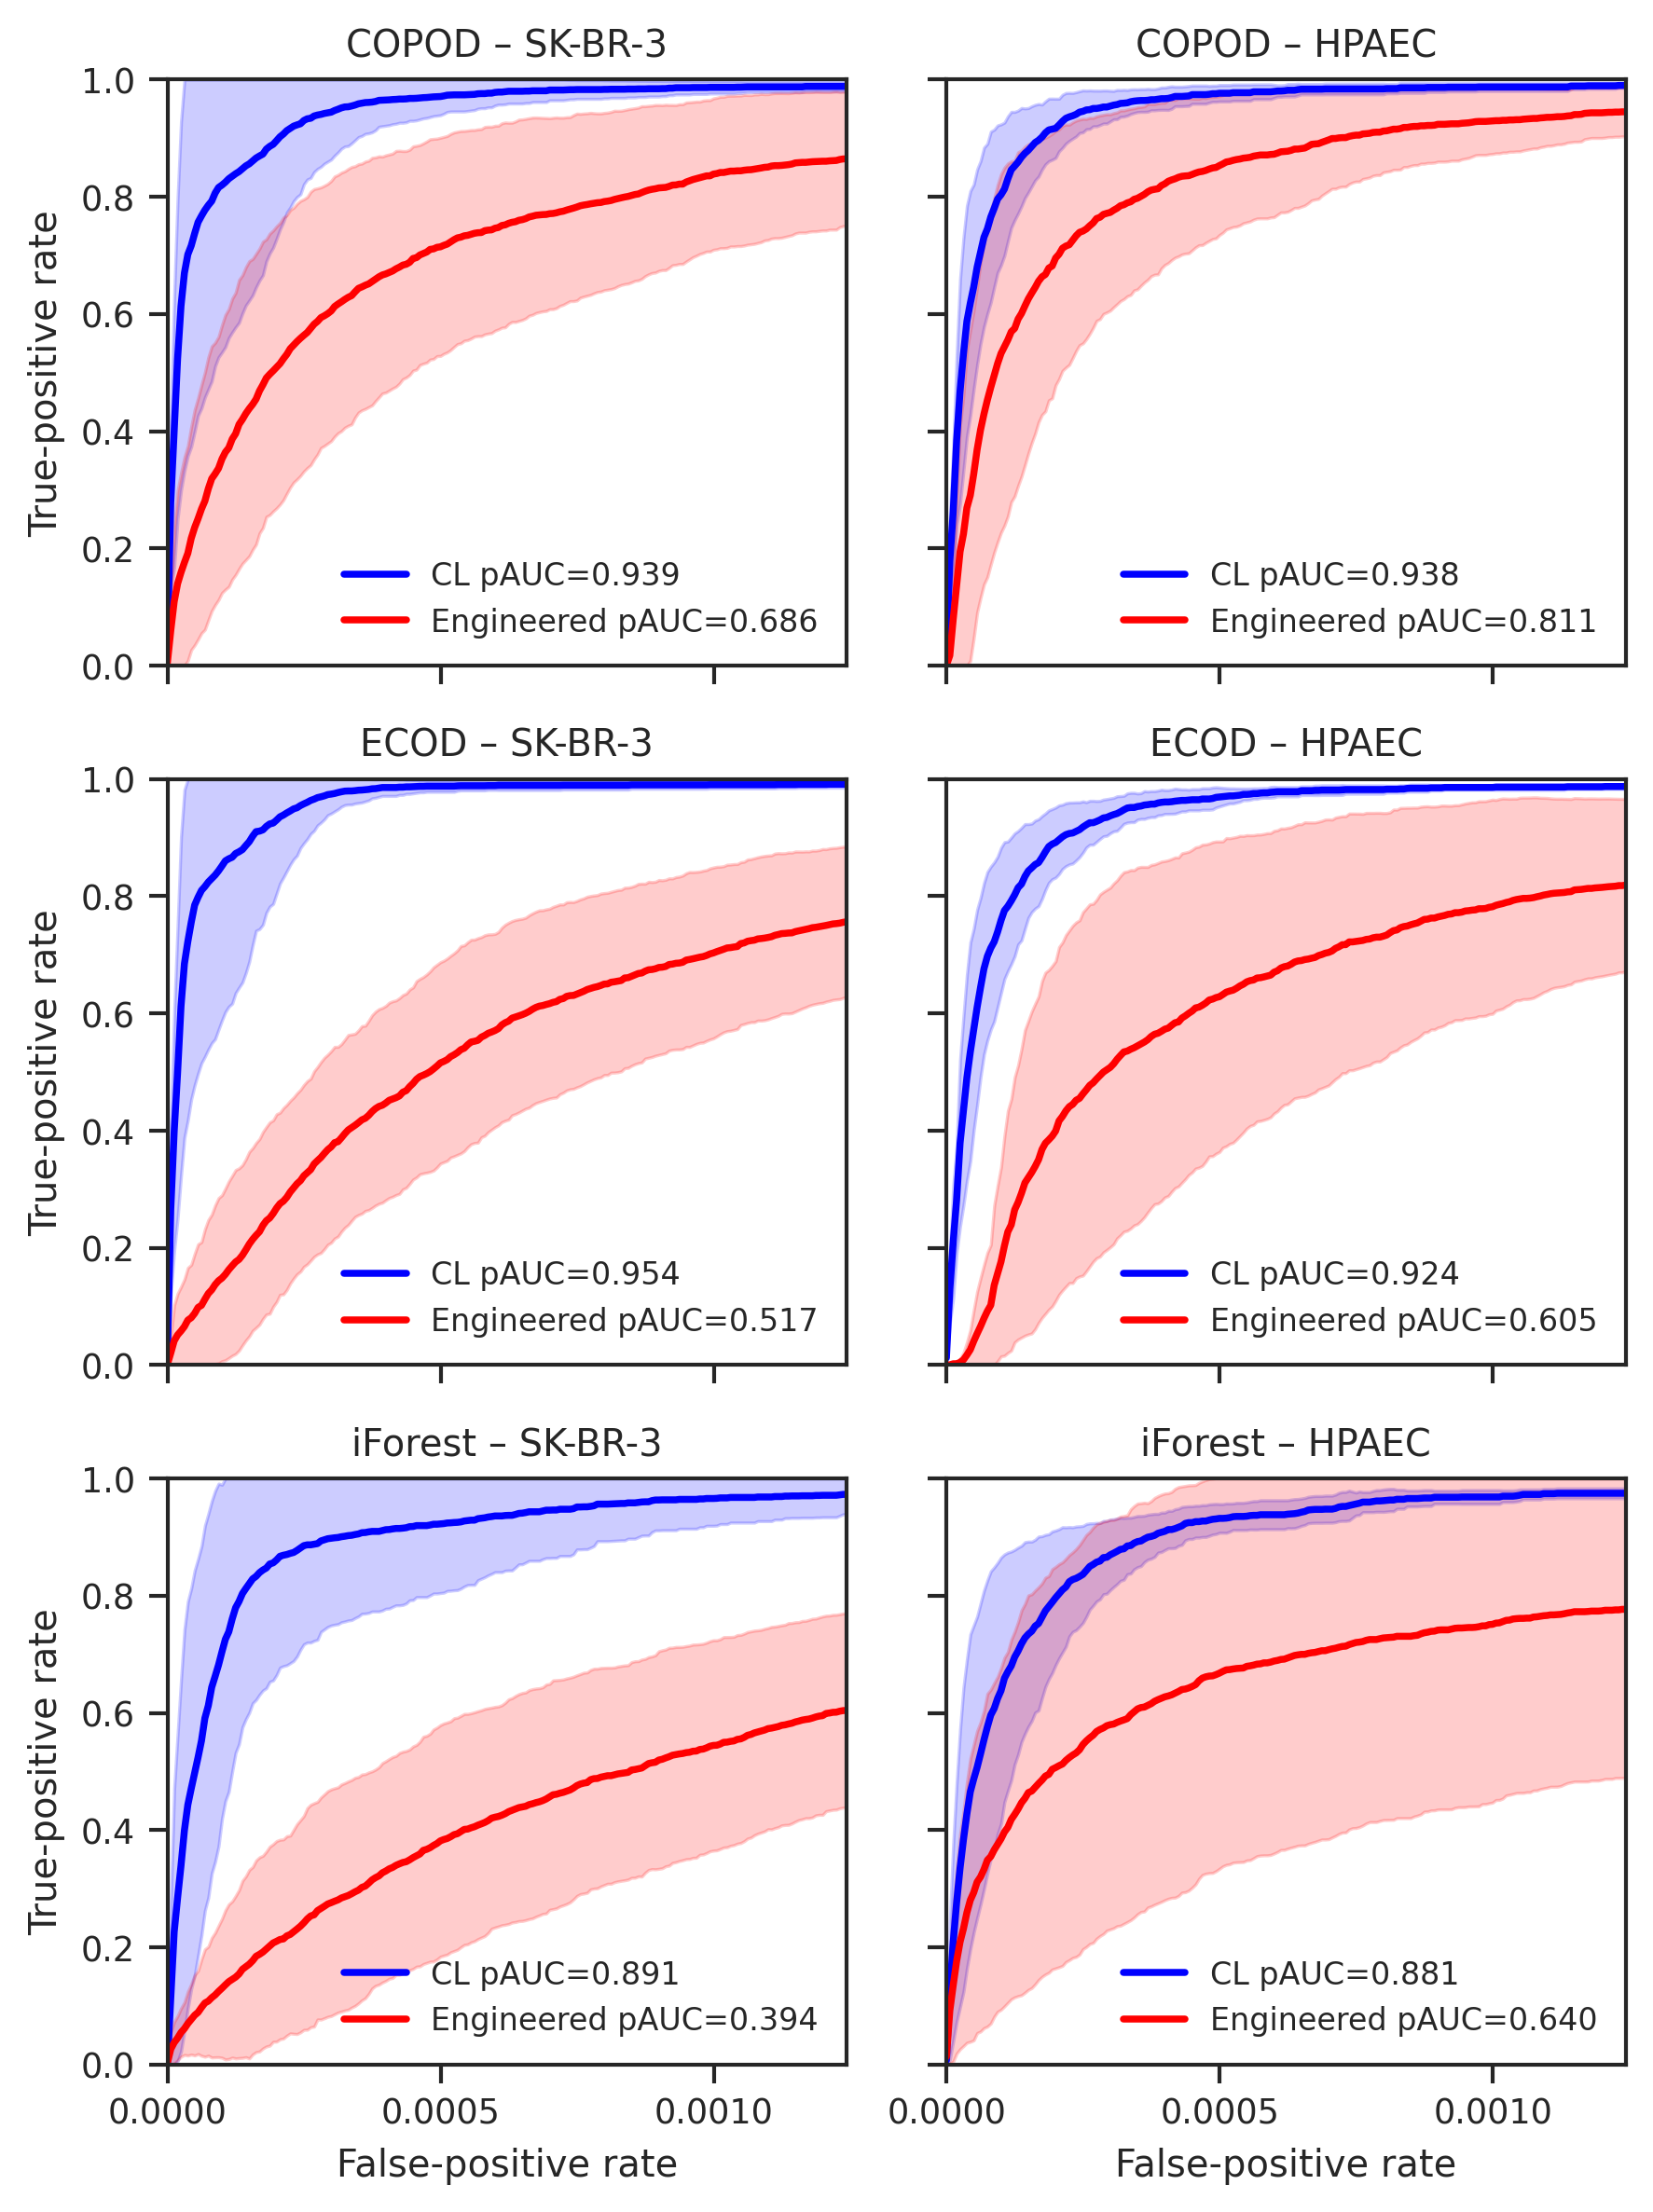

In [9]:
# ─── PLOTTING ────────────────────────────────────────────────────────────────
import numpy as np

# colors for the two pipelines
colors = {'CL': 'blue', 'Engineered': 'red'}

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(6, 8), dpi=300,
    sharex=True, sharey=True
)

for row_idx, det_name in enumerate(detectors):
    for col_idx, cls in enumerate(CLASSES):
        ax = axes[row_idx, col_idx]

        # plot each pipeline
        any_data = False
        for pipe_name in pipelines:
            if pipe_name == 'Eng PCA':  
                continue
            curves = tpr_curves[det_name][cls][pipe_name]
            if not curves:
                continue
            any_data = True

            arr = np.vstack(curves)
            mean_tpr = arr.mean(axis=0)
            std_tpr  = arr.std(axis=0, ddof=1)
            p_auc    = np.trapz(mean_tpr, fpr_grid) / FPR_MAX

            ax.plot(
                fpr_grid, mean_tpr,
                color=colors[pipe_name],
                lw=1.8,
                label=f"{pipe_name} pAUC={p_auc:.3f}"
            )
            ax.fill_between(
                fpr_grid,
                np.clip(mean_tpr - std_tpr, 0, 1),
                np.clip(mean_tpr + std_tpr, 0, 1),
                color=colors[pipe_name],
                alpha=0.2
            )

        if not any_data:
            ax.axis('off')
            ax.set_title(f"{det_name} – Class {cls}: no positives")
        else:
            ax.set_xlim(0, FPR_MAX)
            ax.set_ylim(0, 1)
            ax.set_xticks(np.arange(0, FPR_MAX + 0.0001, 0.0005))
            
            if row_idx == 2:
                ax.set_xlabel("False-positive rate")
            if col_idx == 0:
                ax.set_ylabel("True-positive rate")
            if cls == 1:
                ax.set_title(f"{det_name} – SK-BR-3")
            else:
                ax.set_title(f"{det_name} – HPAEC")
            ax.legend(frameon=False, loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig(
    'outlier_detection_figure.pdf',
    dpi=600, bbox_inches='tight'
)
plt.show()


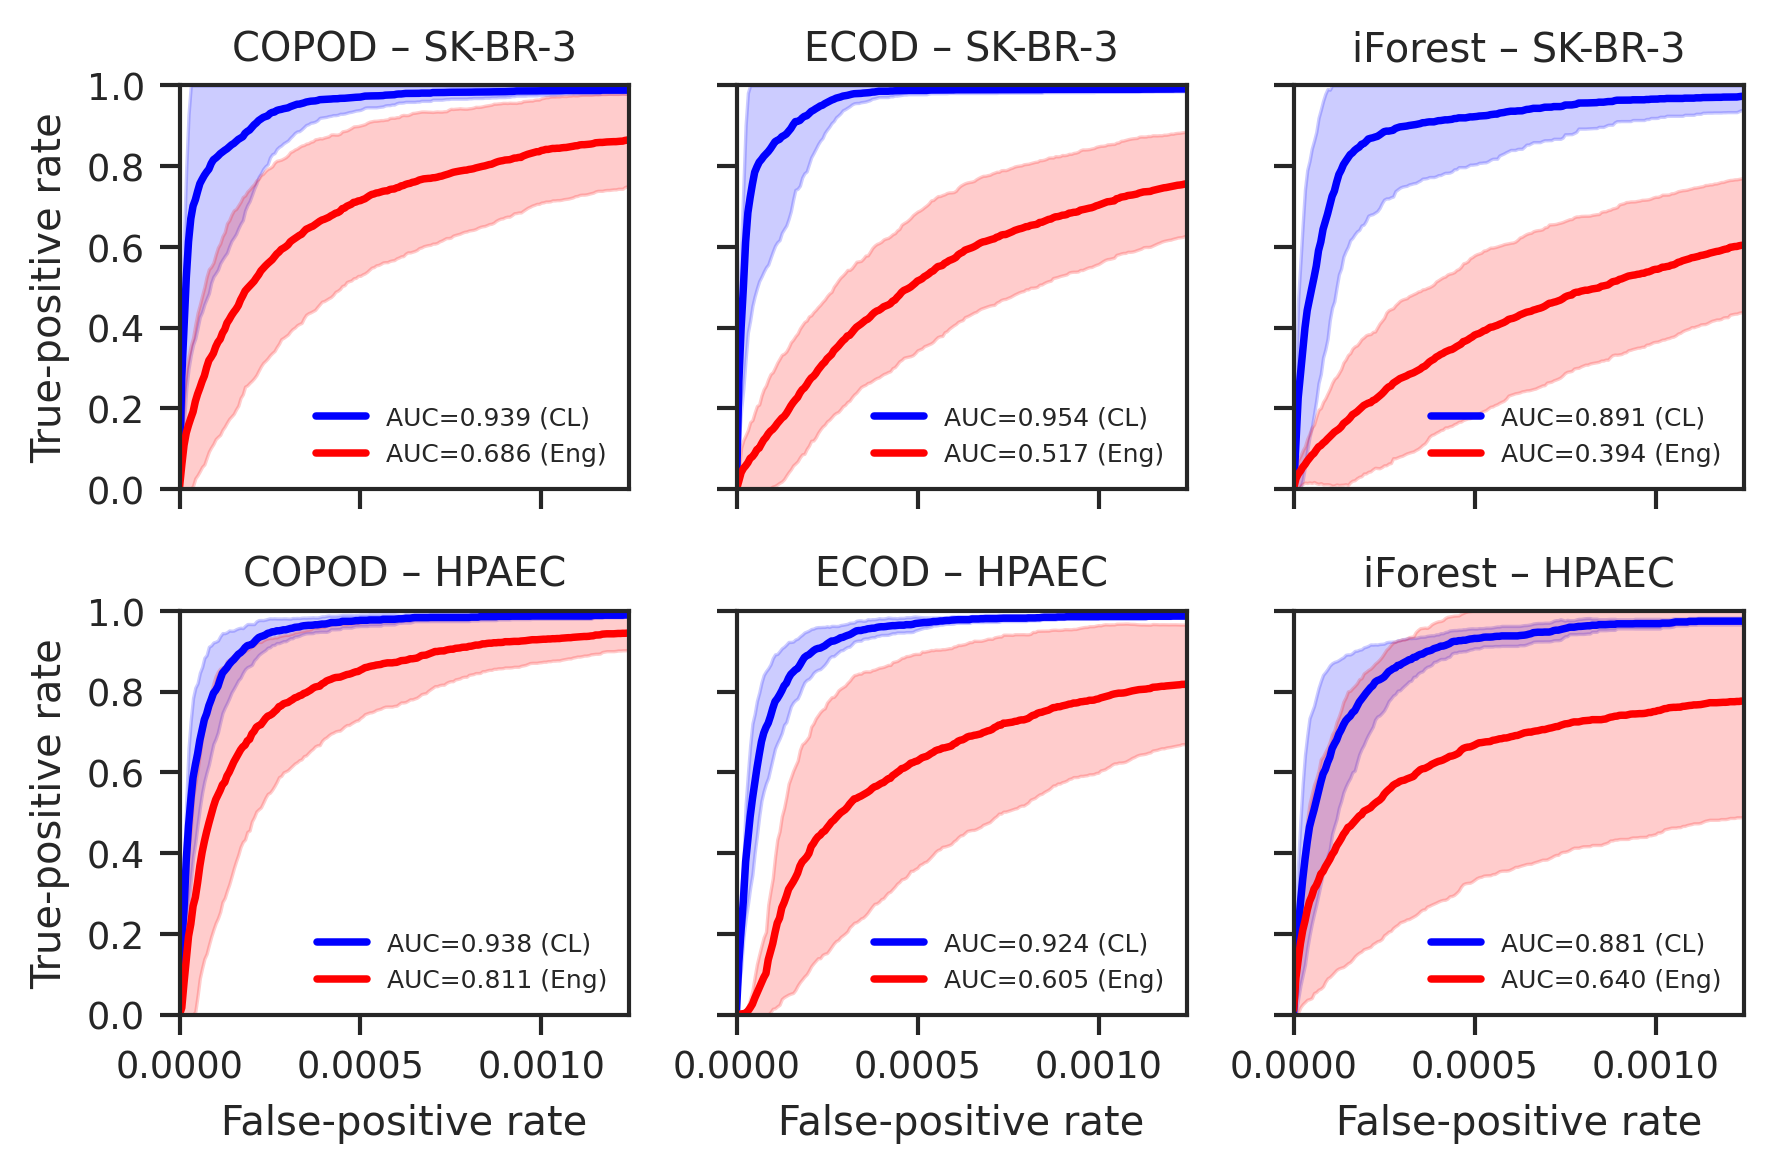

In [14]:
# ─── PLOTTING ────────────────────────────────────────────────────────────────
import numpy as np

# colours for the two pipelines
colors = {'CL': 'blue', 'Eng': 'red'}

# 2 rows × 3 columns, 6″×4″  ⬅️ NEW
fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(6, 4), dpi=300,
    sharex=True, sharey=True
)

# NOTE: rows are now CLASSES (2), columns are detectors (3)  ⬅️ NEW
for row_idx, cls in enumerate(CLASSES):
    for col_idx, det_name in enumerate(detectors):
        ax = axes[row_idx, col_idx]

        # plot each pipeline
        any_data = False
        for pipe_name in pipelines:
            if pipe_name == 'Eng PCA':
                continue
            curves = tpr_curves[det_name][cls][pipe_name]
            if not curves:
                continue
            any_data = True

            arr = np.vstack(curves)
            mean_tpr = arr.mean(axis=0)
            std_tpr  = arr.std(axis=0, ddof=1)
            p_auc    = np.trapz(mean_tpr, fpr_grid) / FPR_MAX

            if pipe_name == 'Engineered':
                pipe_name = 'Eng'

            ax.plot(
                fpr_grid, mean_tpr,
                color=colors[pipe_name],
                lw=1.8,
                label=f"AUC={p_auc:.3f} ({pipe_name})"
            )
            ax.fill_between(
                fpr_grid,
                np.clip(mean_tpr - std_tpr, 0, 1),
                np.clip(mean_tpr + std_tpr, 0, 1),
                color=colors[pipe_name],
                alpha=0.20
            )

        if not any_data:
            ax.axis('off')
            ax.set_title(f"{det_name} – Class {cls}: no positives")
        else:
            ax.set_xlim(0, FPR_MAX)
            ax.set_ylim(0, 1)
            ax.set_xticks(np.arange(0, FPR_MAX + 1e-4, 5e-4))

            # bottom row gets x-axis label  ⬅️ NEW
            if row_idx == 1:
                ax.set_xlabel("False-positive rate")
            # first column gets y-axis label (detector index 0)  ⬅️ unchanged logic
            if col_idx == 0:
                ax.set_ylabel("True-positive rate")

            # concise subplot titles
            ax.set_title(f"{det_name} – {'SK-BR-3' if cls == 1 else 'HPAEC'}")
            ax.legend(frameon=False, loc='lower right', fontsize=6)

plt.tight_layout()
plt.savefig(
    'outlier_detection_figure_wide.pdf',
    dpi=600, bbox_inches='tight'
)
plt.show()
